# Choosing the Best Model

In the previous step, we looked at an attempt to predict the 2017 Tournament and examined the SVC model. Here, we will use the most recent year, 2023 to do our model experimentation. Because of that, we will use a more extensive [dataset folder](https://www.kaggle.com/competitions/march-machine-learning-mania-2023/data).

## Data Preparation and Feature Selection

We mill mainly use code from the 2017 [example from before](https://github.com/adeshpande3/March-Madness-2017) and adjust it to 2023.

In [244]:
import pandas as pd
import numpy as np
import collections

In [395]:
reg_season_compact_pd = pd.read_csv('Data/MRegularSeasonCompactResults.csv') 
reg_season_detailed_pd = pd.read_csv('Data/MRegularSeasonDetailedResults.csv')
teams_pd = pd.read_csv('Data/MTeams.csv')
tourney_compact_pd = pd.read_csv('Data/MNCAATourneyCompactResults.csv')
tourney_detailed_pd = pd.read_csv('Data/MNCAATourneyDetailedResults.csv')
tourney_seeds_pd = pd.read_csv('Data/MNCAATourneySeeds.csv')
conference_tourney_results_pd = pd.read_csv('Data/MConferenceTourneyGames.csv')
conferences_pd = pd.read_csv('Data/MTeamConferences.csv')
seeds_pd = pd.read_csv('Data/MNCAATourneySeeds.csv')

l = []
for i in range(len(conference_tourney_results_pd) - 1):
    if conference_tourney_results_pd.iloc[i, 1] != conference_tourney_results_pd.iloc[i + 1, 1]:
        season = conference_tourney_results_pd.iloc[i, 0]
        conference = conference_tourney_results_pd.iloc[i, 1]
        winner = conference_tourney_results_pd.iloc[i, 3]
        l.append({'Season': season, 'Conference': conference, 'Winner': winner})
        
conference_tourney_winners_pd = pd.DataFrame(l)

We will unfortunately not use a lot of the features presented last time, but we will use the following:

- Regular Season Wins
- Points per game season average
- Points per game allowed season average
- Whether or not in Power 6 conference (ACC, Big Ten, Big 12, SEC, Pac 12, Big East) - Binary label
- Number of 3's per game
- Turnovers per game average
- Assists per game average
- Conference Tournament Championship - binary label
- Tournament Seed
- Rebounds per game average
- Steals per game average
- Number of NCAA appearances since 1985

In [453]:
def getTeamID(name):
    return teams_pd[teams_pd['TeamName'] == name].values[0][0]

def getTeamName(team_id):
    return teams_pd[teams_pd['TeamID'] == team_id].values[0][1]

def getRegSeasonWins(team_id, year):
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    return len(reg_season_compact_pd[c1 & c2])

def getPPG(team_id, year):
    ppg = 0
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    c3 = reg_season_compact_pd['LTeamID'] == team_id
    gamesWon = reg_season_compact_pd[c1 & c2]
    ppg = gamesWon['WScore'].sum()
    gamesLost = reg_season_compact_pd[c2 & c3]
    ppg += gamesLost['LScore'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    ppg /= total_games
    return round(ppg, 2)

def getOPPG(team_id, year):
    oppg = 0
    c1 = reg_season_compact_pd['WTeamID'] == team_id
    c2 = reg_season_compact_pd['Season'] == year
    c3 = reg_season_compact_pd['LTeamID'] == team_id
    gamesWon = reg_season_compact_pd[c1 & c2]
    oppg = gamesWon['LScore'].sum()
    gamesLost = reg_season_compact_pd[c2 & c3]
    oppg += gamesLost['WScore'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    oppg /= total_games
    return round(oppg, 2)

ACC = [1181, 1314, 1323, 1274, 1448, 1438, 1439, 1199, 1393, 1155, 1257, 1130, 1338, 1210, 1301]
Big12 = [1242, 1124, 1403, 1400, 1395, 1329, 1235, 1328, 1243, 1452]
BigEast = [1437, 1344, 1163, 1166, 1371, 1266, 1462, 1385, 1177, 1139, 1207]
Big10 = [1458, 1228, 1345, 1234, 1326, 1353, 1276, 1277, 1321, 1231, 1268, 1336, 1278, 1304]
Pac12 = [1112, 1113, 1417, 1425, 1160, 1450, 1449, 1332, 1333, 1143, 1390, 1428]
SEC = [1120, 1397, 1246, 1116, 1401, 1261, 1196, 1376, 1104, 1280, 1435, 1281, 1279, 1208]

def getPower6(team_id):
    if team_id in ACC or team_id in Big12 or team_id in BigEast or team_id in Big10 or team_id in Pac12 or team_id in SEC:
        return 1
    else:
        return 0

def get3PT(team_id, year):
    if year < 2003:
        return 0
    threes = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    threes = gamesWon['WFGM3'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    threes += gamesLost['LFGM3'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    threes /= total_games
    return round(threes, 2)
    
def getTO(team_id, year):
    if year < 2003:
        return 0
    to = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    to = gamesWon['WTO'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    to += gamesLost['LTO'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    to /= total_games
    return round(to, 2)

def getAST(team_id, year):
    if year < 2003:
        return 0
    ast = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    ast = gamesWon['WAst'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    ast += gamesLost['LAst'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    ast /= total_games
    return round(ast, 2)

def getTourneyConferenceChampion(team_id, year):
    if year < 2001:
        return 0
    conf = getConference(team_id, year)
    c1 = conference_tourney_winners_pd['Season'] == year
    c2 = conference_tourney_winners_pd['Conference'] == conf
    if len(conference_tourney_winners_pd[c1 & c2]) == 0:
        return 0
    if team_id == conference_tourney_winners_pd[c1 & c2]['Winner'].values[0]:
        return 1
    else:
        return 0

def getConference(team_id, year):
    c1 = conferences_pd['TeamID'] == team_id
    c2 = conferences_pd['Season'] == year
    c3 = conferences_pd[c1 & c2]
    if len(c3) == 0:
        return conferences_pd[c1].values[0][2]
    return c3['ConfAbbrev'].values[0]
    
def getSeed(team_id, year):
    c1 = seeds_pd['TeamID'] == team_id
    c2 = seeds_pd['Season'] == year
    if len(seeds_pd[c1 & c2]) == 0:
        return 0
    return int(seeds_pd[c1 & c2]['Seed'].values[0][1:3])

def getRPG(team_id, year):
    if year < 2003:
        return 0
    reb = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    reb = gamesWon['WOR'].sum()
    reb += gamesWon['WDR'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    reb += gamesLost['LOR'].sum()
    reb += gamesLost['LDR'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    reb /= total_games
    return round(reb, 2)

def getSTL(team_id, year):
    if year < 2003:
        return 0
    stl = 0
    c1 = reg_season_detailed_pd['WTeamID'] == team_id
    c2 = reg_season_detailed_pd['Season'] == year
    c3 = reg_season_detailed_pd['LTeamID'] == team_id
    gamesWon = reg_season_detailed_pd[c1 & c2]
    stl = gamesWon['WStl'].sum()
    gamesLost = reg_season_detailed_pd[c2 & c3]
    stl += gamesLost['LStl'].sum()
    total_games = len(gamesWon) + len(gamesLost)
    stl /= total_games
    return round(stl, 2)

def getNumOfAppearances(team_id):
    return len(tourney_seeds_pd[tourney_seeds_pd['TeamID'] == team_id])

def getHomeStat(row):
    if (row == 'H'):
        home = 1
    if (row == 'A'):
        home = -1
    if (row == 'N'):
        home = 0
    return home

def getSeasonData(team_id, year):
    # Check first if the team was Division 1 at the time
    c1 = teams_pd[teams_pd['TeamID'] == team_id]['FirstD1Season'].values[0] <= year
    c2 = teams_pd[teams_pd['TeamID'] == team_id]['LastD1Season'].values[0] >= year
    if ~c1 or ~c2:
        return []
    return [getRegSeasonWins(team_id, year),
            getPPG(team_id, year),
            getOPPG(team_id, year),
            getPower6(team_id),
            get3PT(team_id, year),
            getTO(team_id, year),
            getAST(team_id, year),
            getTourneyConferenceChampion(team_id, year),
            getSeed(team_id, year),
            getRPG(team_id, year),
            getSTL(team_id, year),
            getNumOfAppearances(team_id)]

def createSeasonDict(year):
    seasonDictionary = collections.defaultdict(list)
    for team in teams_pd['TeamName'].tolist():
        team_id = teams_pd[teams_pd['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary

In [466]:
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1181,2012)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

We will not use the entire dataset since we will be using lots of models, and that will be time consuming trying to fit those models (*cough* SVC *cough*). But we should still get a very good idea on how these models will fare for the newer data, and it should translate well historically. In Step 9 when we scale our dataset, we will use the entire dataset, but for now, we will use the previous year. 

In [501]:
x_data, y_data = createTrainingSet([2022])
np.save('x_dataset', x_data)
np.save('y_dataset', y_data)

In [502]:
xTrain = np.load('x_dataset.npy')
yTrain = np.load('y_dataset.npy')
xTrain.shape

(5412, 13)

## Testing Various Models

Now we enter the point where we look into the various classification models in depth. We well all do hyperparamter tuning on them via `GridSearchCV()` to give everyone a fair shot. Finally, they will be put to the test to see who can predict the first round of the 2022 tournament the best.

In [742]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size = .3, random_state = 942)
results = []

In [741]:
# Making the list of First Round Games
c1 = tourney_detailed_pd['DayNum'] == 136
c2 = tourney_detailed_pd['DayNum'] == 137
c3 = tourney_detailed_pd['Season'] == 2022
first_round_2022_pd = tourney_detailed_pd[(c1 | c2) & c3]

d = {'WTeamID': first_round_2022_pd['WTeamID'].tolist(),
     'LTeamID': first_round_2022_pd['LTeamID'].tolist()
    }

first_round_2022_prediction_pd = pd.DataFrame(d)
first_round_2022_prediction_pd.head()

,WTeamID,LTeamID
0,1116,1436
1,1124,1313
2,1166,1361
3,1211,1209
4,1242,1411


In [678]:
# Functions to predict probability that Team 1 wins given both teams and the model
def predictOutcome(w_data, l_data, model):
    diff = [a - b for a, b in zip(w_data, l_data)]
    diff.append(0)
    return model.predict_proba([diff])[0]

Furthermore, we will examine 5 games to help us choose our model for the next step. They are:

1) (1)Gonzaga vs. (16)Georgia St. where Gonzaga won pretty handily. (1211 vs. 1209)
2) (4)UCLA vs. (13)Akron where UCLA just barely survives. (1417 vs. 1103)
3) (8)North Carolina vs. (9)Marquette where North Carolina just completely dominates (1314 vs. 1266)
4) (11)Notre Dame vs. (6)Alabama where Notre Dame easily denies the Crimson Tide (1323 vs. 1104)
5) (15)St. Peter's vs. (2)Kentucky where St. Peter's pulls off the greatest upset this round. (1389 vs. 1246)

### SVC

In [679]:
from sklearn.svm import SVC

According to the research paper from last step, the Linear SVC gave the best accuracy. Let us see how it stands the test of time. Unfortunately, this will take a while to run, and afterwards doing some hyperparamter tuning... pass.

#### Linear SVC

In [749]:
model_SVC_linear = SVC(kernel = 'linear')
model_SVC_linear = model_SVC_linear.fit(X_train, y_train)
y_pred_SVC_linear = model_SVC_linear.predict(X_test)

print(classification_report(y_test, y_pred_SVC_linear))
model_SVC_accuracy_linear = accuracy_score(y_test, y_pred_SVC_linear)
model_SVC_accuracy_linear = round(model_SVC_accuracy_linear, 4)
model_SVC_accuracy_linear

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       791
         1.0       0.76      0.73      0.74       833

    accuracy                           0.74      1624
   macro avg       0.74      0.74      0.74      1624
weighted avg       0.74      0.74      0.74      1624



0.742

In [693]:
model_SVC_linear_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

from sklearn.calibration import CalibratedClassifierCV
cc_linear = CalibratedClassifierCV(model_SVC_linear)
cc_linear.fit(X_train, y_train)

for i in range(len(model_SVC_linear_prediction_pd)):
    w_team = model_SVC_linear_prediction_pd.iloc[i, 0]
    l_team = model_SVC_linear_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, cc_linear)
    probabilities.append(prob)

In [719]:
probabilites = np.array(probabilities)
model_SVC_linear_prediction_pd['Linear_SVC_Probabilites'] = probabilites[:, 1]
model_SVC_linear_prediction_pd['Linear_SVC_Probabilites'].describe()

count    32.000000
mean      0.674535
std       0.272790
min       0.034972
25%       0.506967
50%       0.727449
75%       0.919946
max       0.978470
Name: Linear_SVC_Probabilites, dtype: float64

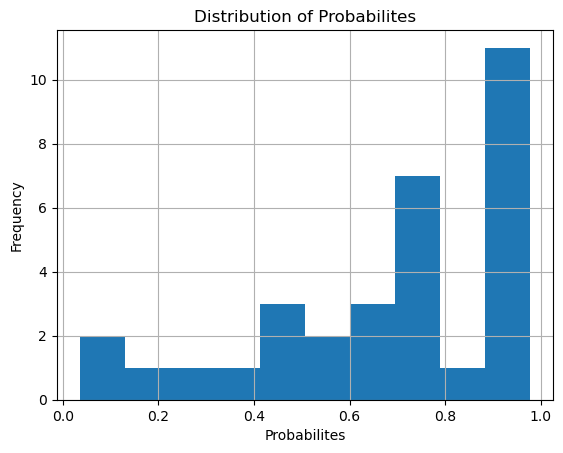

Accuracy for Predicting Round 1 is: 0.75


In [722]:
import matplotlib.pyplot as plt
%matplotlib inline

model_SVC_linear_prediction_pd['Linear_SVC_Probabilites'].hist(bins = 10)
plt.xlabel("Probabilites")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilites")
plt.show()
model_SVC_accuracy_linear_tournament = len(model_SVC_linear_prediction_pd[model_SVC_linear_prediction_pd['Linear_SVC_Probabilites'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_SVC_accuracy_linear_tournament)

In [731]:
print("Gonzaga vs. Georgia St. Prediction:", model_SVC_linear_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_SVC_linear_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_SVC_linear_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_SVC_linear_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_SVC_linear_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.9256836804285434
UCLA vs. Akron Prediction: 0.9180336819628374
North Carolina vs. Marquette: 0.733227431912017
Notre Dame vs. Alabama: 0.6255782369476646
St. Peter's vs. Kentucky: 0.03497230919533634


In [743]:
results.append({'Name': 'Linear_SVC',
                'Training_Acc': model_SVC_accuracy_linear,
                'Tournament_Acc': model_SVC_accuracy_linear_tournament
               })

It seems like the Linear SVC displayed a 74.2% accuracy on the training data. But when it came to the Tournament data, it scored a benchmark 75% accuracy. The lowest accuracy recorded was 3.497% which came from St. Peter's vs. Kentucky. The model also correctly predicted the 4 games shown just above including the upset by Notre Dame. All in all, if it were not for the runtime of SVC's we would go with them 100%.

In [750]:
# Radial Kernel
model_SVC_rbf = SVC(kernel = 'rbf')
model_SVC_rbf = model_SVC_rbf.fit(X_train, y_train)
y_pred_SVC_rbf = model_SVC_rbf.predict(X_test)

print(classification_report(y_test, y_pred_SVC_rbf))
model_SVC_accuracy_rbf = accuracy_score(y_test, y_pred_SVC_rbf)
model_SVC_accuracy_rbf = round(model_SVC_accuracy_rbf, 4)
model_SVC_accuracy_rbf

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75       791
         1.0       0.76      0.73      0.75       833

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



0.7451

In [733]:
model_SVC_rbf_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

cc_rbf = CalibratedClassifierCV(model_SVC_rbf)
cc_rbf.fit(X_train, y_train)

for i in range(len(model_SVC_rbf_prediction_pd)):
    w_team = model_SVC_rbf_prediction_pd.iloc[i, 0]
    l_team = model_SVC_rbf_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, cc_rbf)
    probabilities.append(prob)

In [734]:
probabilites = np.array(probabilities)
model_SVC_rbf_prediction_pd['Radial_SVC_Probabilites'] = probabilites[:, 1]
model_SVC_rbf_prediction_pd['Radial_SVC_Probabilites'].describe()

count    32.000000
mean      0.631059
std       0.203303
min       0.202225
25%       0.422035
50%       0.736533
75%       0.791780
max       0.873147
Name: Radial_SVC_Probabilites, dtype: float64

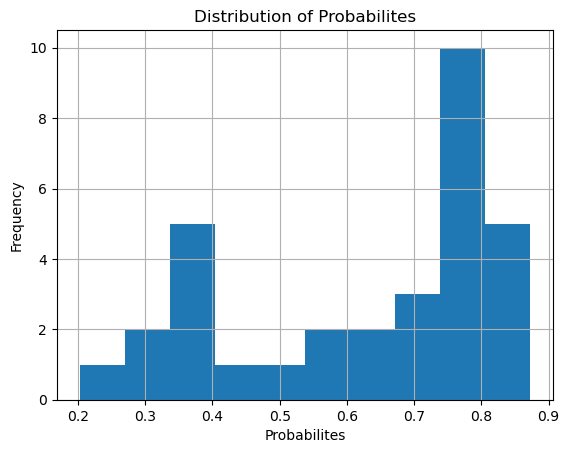

Accuracy for Predicting Round 1 is: 0.6875


In [738]:
model_SVC_rbf_prediction_pd['Radial_SVC_Probabilites'].hist(bins = 10)
plt.xlabel("Probabilites")
plt.ylabel("Frequency")
plt.title("Distribution of Probabilites")
plt.show()
model_SVC_accuracy_rbf_tournament = len(model_SVC_rbf_prediction_pd[model_SVC_rbf_prediction_pd['Radial_SVC_Probabilites'] >= .5]) / 32
print("Accuracy for Predicting Round 1 is:", model_SVC_accuracy_rbf_tournament)

In [739]:
print("Gonzaga vs. Georgia St. Prediction:", model_SVC_rbf_prediction_pd.iloc[3, 2])
print("UCLA vs. Akron Prediction:", model_SVC_rbf_prediction_pd.iloc[15, 2])
print("North Carolina vs. Marquette:", model_SVC_rbf_prediction_pd.iloc[9, 2])
print("Notre Dame vs. Alabama:", model_SVC_rbf_prediction_pd.iloc[24, 2])
print("St. Peter's vs. Kentucky:", model_SVC_rbf_prediction_pd.iloc[13, 2])

Gonzaga vs. Georgia St. Prediction: 0.7357289541652939
UCLA vs. Akron Prediction: 0.8206063842196869
North Carolina vs. Marquette: 0.805882675989535
Notre Dame vs. Alabama: 0.7428491064723785
St. Peter's vs. Kentucky: 0.3236485942620432


In [747]:
results.append({'Name': 'Radial_SVC',
                'Training_Acc': model_SVC_accuracy_rbf, 
                'Tournament_Acc': model_SVC_accuracy_rbf_tournament
               })

Despite having a slightly higher training accuracy than its linear counterpart, it did very poorly on predicting the tournament with a 68.75% accuracy. The most suprising thing, however is that it gave St. Peter's a 32.36% chance to beat Kentucky. Although we will not use this model, it was still a very good effort.

In [552]:
# Varying Degree Polynomials
from sklearn.model_selection import GridSearchCV

param_grid_SVC_poly = {'degree': [0, 2, 3, 4]}
grid_SVC_poly = GridSearchCV(SVC(kernel = 'poly'), param_grid = param_grid_SVC_poly, cv = 3, n_jobs = -1)
grid_SVC_poly = grid_SVC_poly.fit(X_train, y_train)
print("Best: %f using %s" % (grid_SVC_poly.best_score_, grid_SVC_poly.best_params_))

Best: 0.738912 using {'degree': 3}


In [748]:
model_SVC_deg3 = SVC(kernel = 'poly', degree = 3)
model_SVC_deg3 = model_SVC_deg3.fit(X_train, y_train)
y_pred_SVC_deg3 = model_SVC_deg3.predict(X_test)

print(classification_report(y_test, y_pred_SVC_deg3))
model_SVC_accuracy_deg3 = accuracy_score(y_test, y_pred_SVC_deg3)
model_SVC_accuracy_deg3 = round(model_SVC_accuracy_rbf, 4)
model_SVC_accuracy_deg3

              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       791
         1.0       0.77      0.73      0.75       833

    accuracy                           0.75      1624
   macro avg       0.75      0.75      0.75      1624
weighted avg       0.75      0.75      0.75      1624



0.745

In [751]:
model_SVC_deg3_prediction_pd = first_round_2022_prediction_pd.copy()

probabilities = []

cc_deg3 = CalibratedClassifierCV(model_SVC_deg3)
cc_deg3.fit(X_train, y_train)

for i in range(len(model_SVC_deg3_prediction_pd)):
    w_team = model_SVC_deg3_prediction_pd.iloc[i, 0]
    l_team = model_SVC_deg3_prediction_pd.iloc[i, 1]
    w_data = getSeasonData(w_team, 2022)
    l_data = getSeasonData(l_team, 2022)
    prob = predictOutcome(w_data, l_data, cc_deg3)
    probabilities.append(prob)

In [752]:
probabilites = np.array(probabilities)
model_SVC_deg3_prediction_pd['Degree3_SVC_Probabilites'] = probabilites[:, 1]
model_SVC_deg3_prediction_pd['Degree3_SVC_Probabilites'].describe()

count    32.000000
mean      0.664924
std       0.236200
min       0.099157
25%       0.457032
50%       0.659261
75%       0.875955
max       0.998751
Name: Degree3_SVC_Probabilites, dtype: float64

### Logistic Regression

Unlike SVC, `GridSearchCV` will not take forever.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_logreg = LogisticRegression()
model_logreg = model_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)

print(classification_report(y_test, y_pred_logreg))
model_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
model_logreg_accuracy

In [546]:
params_logreg = {'penalty': [None, 'l1', 'l2'],
                 'dual': [True, False],
                 'tol': [1, .1, .01, .001],
                 'C': [.1, 1, 10, 100],
                 'fit_intercept': [True, False]
                 }

grid_logreg = GridSearchCV(LogisticRegression(), param_grid = params_logreg, n_jobs = -1, cv = 5)
grid_logreg = grid_logreg.fit(X_train, y_train)
print("Best: %f using %s" % (grid_logreg.best_score_, grid_logreg.best_params_))

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklea

Best: 0.749208 using {'C': 0.1, 'dual': False, 'fit_intercept': False, 'penalty': None, 'tol': 0.1}


/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/janjacob/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
